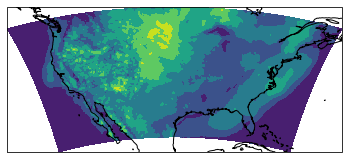

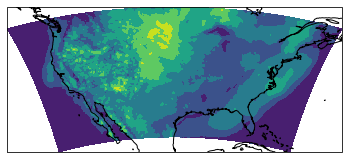

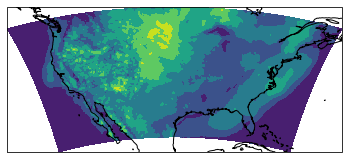

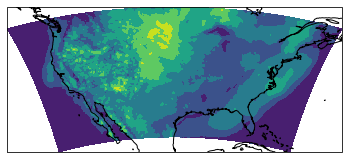

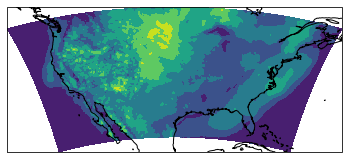

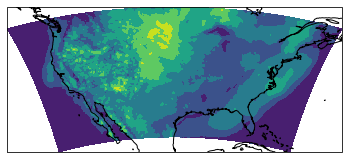

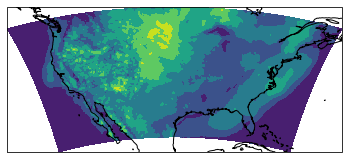

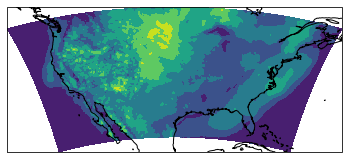

2min 2s ± 1.65 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
import s3fs
import xarray as xr
import metpy
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def load_dataset(urls):
    fs = s3fs.S3FileSystem(anon=True)
    ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr')
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(grid_mapping_name="lambert_conformal_conic", longitude_of_central_meridian=-97.5,
                                 latitude_of_projection_origin=38.5,
                                 standard_parallel=38.5)
    ds = ds.metpy.assign_latitude_longitude()
    ds = ds.set_coords("time")
    return ds

def load_combined_dataset(start_date, num_hours, level, param_short_name):
    combined_ds = None
    for i in range(num_hours):
        time = start_date + datetime.timedelta(hours=i)
        group_url = time.strftime(f"s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{param_short_name}")
        subgroup_url = group_url + f"/{level}"
        partial_ds = load_dataset([group_url, subgroup_url])
        if not combined_ds:
            combined_ds = partial_ds
        else:
            combined_ds = xr.concat([combined_ds, partial_ds], dim="time", combine_attrs="drop_conflicts")
    return combined_ds

ds = load_combined_dataset(datetime.datetime(2021, 4, 1), 24, "1000mb", "TMP")
std_dev = ds.TMP.std(dim="time")

ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(std_dev.longitude, std_dev.latitude, std_dev)
ax.coastlines()

plt.show()

So it's 2 minutes downloading all the data (non-parallel) and creating lat/lon separately for each of them. Let's see if we can improve performance by only creating lat/lon arrays once.

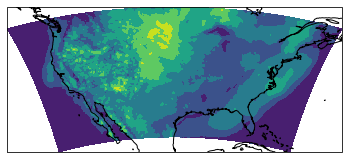

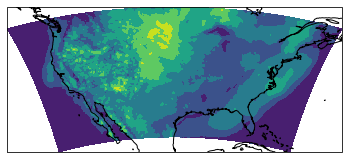

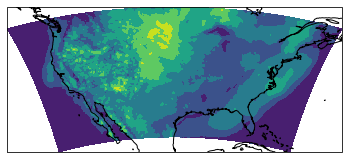

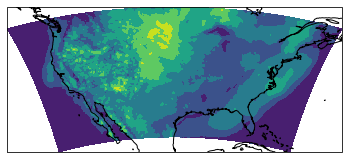

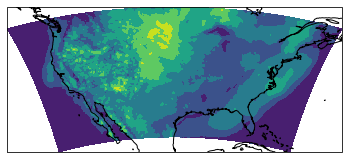

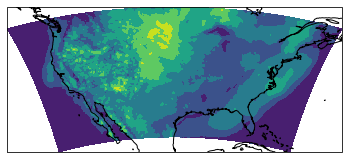

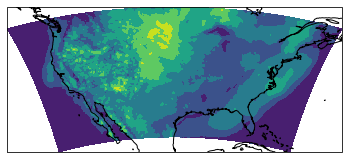

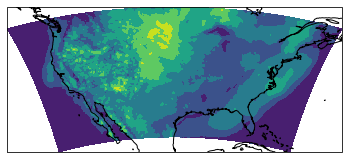

1min 43s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit
import s3fs
import xarray as xr
import metpy
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def load_dataset(urls, latitude=None, longitude=None):
    fs = s3fs.S3FileSystem(anon=True)
    ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr')
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(grid_mapping_name="lambert_conformal_conic", longitude_of_central_meridian=-97.5,
                                 latitude_of_projection_origin=38.5,
                                 standard_parallel=38.5)
    ds = ds.set_coords("time")
    if latitude is None or longitude is None:
        ds = ds.metpy.assign_latitude_longitude()
    else:
        ds = ds.assign_coords({"latitude": latitude, "longitude": longitude})
    return ds

def load_combined_dataset(start_date, num_hours, level, param_short_name):
    combined_ds = None
    for i in range(num_hours):
        time = start_date + datetime.timedelta(hours=i)
        group_url = time.strftime(f"s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{param_short_name}")
        subgroup_url = group_url + f"/{level}"
        if not combined_ds:
            combined_ds = load_dataset([group_url, subgroup_url])
        else:
            partial_ds = load_dataset([group_url, subgroup_url], latitude=combined_ds.latitude, longitude=combined_ds.longitude)
            combined_ds = xr.concat([combined_ds, partial_ds], dim="time", combine_attrs="drop_conflicts")
    return combined_ds

ds = load_combined_dataset(datetime.datetime(2021, 4, 1), 24, "1000mb", "TMP")
std_dev = ds.TMP.std(dim="time")

ax = plt.axes(projection=ccrs.PlateCarree())
ax.contourf(std_dev.longitude, std_dev.latitude, std_dev)
ax.coastlines()

plt.show()

In [5]:
# Fix pyproj SQL error

import pyproj
pyproj.datadir.set_data_dir("/Users/adairkovac/.conda/envs/TetheredBalloon-7710/share/proj")